# **CSCI 4967 Projects in AI/ML HW2**

**Spring 2024**

*Author: Yuming (Tao) Xie*

# 0.&nbsp;Using GPU for Accelerating Process If Necessary

In [4]:
# test if GPU is running
import tensorflow as tf
tf.test.gpu_device_name()
# check which GPU is running
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10983508913157052488
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5500985926859243207
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# 1.&nbsp;Import the Libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 2.&nbsp;Download, Load, Clean and Preprocess the Dataset

In [6]:
# Load the data into a pandas DataFrame
df = pd.read_csv('/content/crx.data', header=None)

The data set from UCI (https://archive.ics.uci.edu/dataset/27/credit+approval) contains 690 information cases and 16 variables (0-15). The first 15 variables (0-14) represent different attributes of each case, and the 16th variable (15) represents the result of the credit card application (′+′ represents the application was approved and ′−′ represents the application was rejected). The
variables for this dataset are composed of continuous, letters, and symbols (class attribute). The table for each variable and the corresponding attribute is as below:

In [7]:
# Display the first 5 rows of the dataframe
print(df.head())

  0      1      2  3  4  5  6     7  8  9   10 11 12     13   14 15
0  b  30.83  0.000  u  g  w  v  1.25  t  t   1  f  g  00202    0  +
1  a  58.67  4.460  u  g  q  h  3.04  t  t   6  f  g  00043  560  +
2  a  24.50  0.500  u  g  q  h  1.50  t  f   0  f  g  00280  824  +
3  b  27.83  1.540  u  g  w  v  3.75  t  t   5  t  g  00100    3  +
4  b  20.17  5.625  u  g  w  v  1.71  t  f   0  f  s  00120    0  +


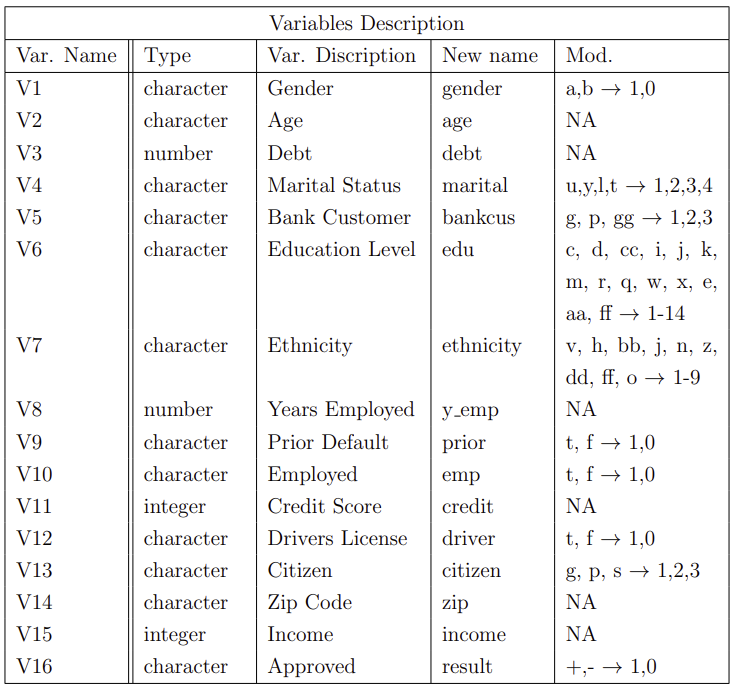

Now check and handle the missing data:

In [8]:
# Replace all "?" with NaN
df = df.replace('?', np.nan)

# Check the missing data
print(df.isnull().sum())

0     12
1     12
2      0
3      6
4      6
5      9
6      9
7      0
8      0
9      0
10     0
11     0
12     0
13    13
14     0
15     0
dtype: int64


The data set contains missing values over 7 of the 16 variables. These missing values
are found in 37 of the 690 cases representing about 5.36% of the data. The missing
values are found in the following attributes: 0(Age), 1(Gender), 3(Marital Status),
4(Bank Customer), 5(Education Level), 6(Ethnicity) and 13(Zip Code). Note
0(age) is the only continuous type and the rest are letters type. There are various
methods to handle these missing values which can range from deleting the observation
reporting the missing data to replacing the missing data with the average of the feature
in which the data is missing. For this data set, I use the mean values to replace the
missing values in Age attribute and delete the rest of the observations which reports
the missing data.

In [9]:
# Handle the missing data, replace NaN in 'V2' with mean
# Make sure 'V2' is numeric
df[1] = pd.to_numeric(df[1], errors='coerce')

# Replace NaN in 'V2' with mean
df[1].fillna(df[1].mean(), inplace=True)

#remove the rest of the missing values
df = df.dropna()

Data Preprocessing: Since all the continuous attributes are measured with different scales along with high
variances, this may affect the analysis by finding improper correlation between each
pair of attributes. Thus in order to get better and more accurate analysis on the
continuous attributes, 1(Age), 2(Debt), 7(Years Employed), 10(Credit Scores),
and 14(Income) are normalized using the Min-Max Scaling.

In [10]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# List of columns to normalize
columns_to_normalize = [1, 2, 7, 10, 14]

# Apply the scaler to the columns
for column in columns_to_normalize:
    df[column] = scaler.fit_transform(df[[column]])

In [11]:
# Data visualization for discrete variables
df[0] = np.where(df[0] == 'a', 1, 0)
df[8] = np.where(df[8] == 't', 1, 0)
df[9] = np.where(df[9] == 't', 1, 0)
df[11] = np.where(df[11] == 't', 1, 0)

df[3] = df[3].map({'u': 1, 'y': 2, 'l': 3, '6': 4})
df[4] = df[4].map({'g': 1, 'p': 2, 'gg': 3})
df[5] = df[5].map({'c': 1, 'd': 2, 'cc': 3, 'i': 4, 'j': 5, 'k': 6, 'm': 7, 'r': 8, 'q': 9, 'w': 10, 'x': 11, 'e': 12, 'aa': 13, 'ff': 14})
df[6] = df[6].map({'v': 1, 'h': 2, 'bb': 3, 'j': 4, 'n': 5, 'z': 6, 'dd': 7, 'ff': 8, 'o': 9})
df[12] = df[12].map({'g': 1, 'p': 2, 's': 3})
df[15] = df[15].map({'+': 1, '-': 0})

# Convert to numeric
for col in [3, 4, 5, 6, 12, 13, 15]:
    df[col] = pd.to_numeric(df[col])

# &nbsp;Task 1: Decision Tree Classifier

In [12]:
X = df.drop(15, axis=1)
y = df[15]
y_bin = label_binarize(y, classes=[0, 1])

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

tree1 = DecisionTreeClassifier()                    # Default
tree2 = DecisionTreeClassifier(splitter='random')   # Split the tree at random pick
tree3 = DecisionTreeClassifier(max_depth = 500)     # With max depth of 500

tree1.fit(X_train, y_train)
tree2.fit(X_train, y_train)
tree3.fit(X_train, y_train)

y_pred1 = tree1.predict(X_test)
y_pred2 = tree2.predict(X_test)
y_pred3 = tree3.predict(X_test)

[Text(0.4869791666666667, 0.9615384615384616, 'x[8] <= 0.5\ngini = 0.498\nsamples = 464\nvalue = [248, 216]'),
 Text(0.18958333333333333, 0.8846153846153846, 'x[2] <= 0.006\ngini = 0.13\nsamples = 214\nvalue = [199, 15]'),
 Text(0.1, 0.8076923076923077, 'x[13] <= 480.0\ngini = 0.408\nsamples = 21\nvalue = [15, 6]'),
 Text(0.08333333333333333, 0.7307692307692307, 'x[5] <= 1.5\ngini = 0.332\nsamples = 19\nvalue = [15, 4]'),
 Text(0.05, 0.6538461538461539, 'x[7] <= 0.035\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(0.03333333333333333, 0.5769230769230769, 'x[7] <= 0.004\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.016666666666666666, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.05, 0.5, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.06666666666666667, 0.5769230769230769, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.11666666666666667, 0.6538461538461539, 'x[14] <= 0.0\ngini = 0.133\nsamples = 14\nvalue = [13, 1]'),
 Text(0.1, 0.5769230769230769, 'gini

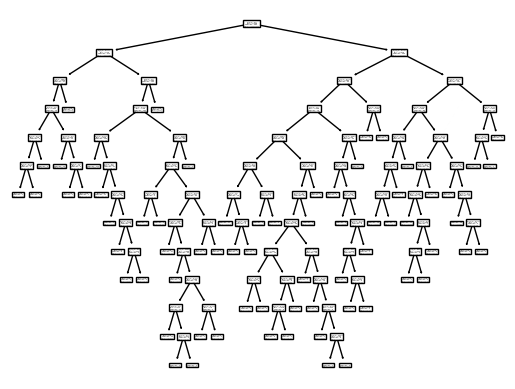

In [13]:
tree.plot_tree(tree1)

In [14]:
# Find confusion matrix
print("Confusion Matrix For Decision Tree Model 1:\n", confusion_matrix(y_test, y_pred1))

Confusion Matrix For Decision Tree Model 1:
 [[100  18]
 [ 14  68]]


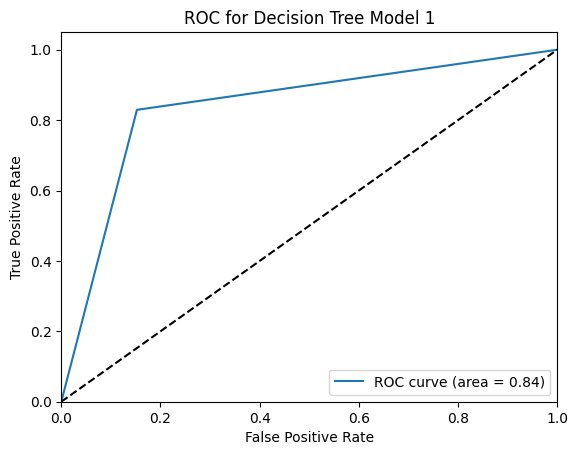

In [15]:
# Compute and plot ROC
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Decision Tree Model 1')
plt.legend(loc="lower right")
plt.show()

[Text(0.468629498714653, 0.9666666666666667, 'x[8] <= 0.255\ngini = 0.498\nsamples = 464\nvalue = [248, 216]'),
 Text(0.2859897172236504, 0.9, 'x[14] <= 0.773\ngini = 0.13\nsamples = 214\nvalue = [199, 15]'),
 Text(0.27570694087403597, 0.8333333333333334, 'x[5] <= 12.255\ngini = 0.123\nsamples = 213\nvalue = [199, 14]'),
 Text(0.2654241645244216, 0.7666666666666667, 'x[1] <= 0.438\ngini = 0.15\nsamples = 171\nvalue = [157, 14]'),
 Text(0.2120822622107969, 0.7, 'x[12] <= 1.108\ngini = 0.137\nsamples = 162\nvalue = [150, 12]'),
 Text(0.15681233933161953, 0.6333333333333333, 'x[9] <= 0.762\ngini = 0.111\nsamples = 136\nvalue = [128, 8]'),
 Text(0.14652956298200515, 0.5666666666666667, 'x[2] <= 0.062\ngini = 0.132\nsamples = 113\nvalue = [105, 8]'),
 Text(0.09768637532133675, 0.5, 'x[7] <= 0.044\ngini = 0.227\nsamples = 46\nvalue = [40, 6]'),
 Text(0.07197943444730077, 0.43333333333333335, 'x[2] <= 0.03\ngini = 0.145\nsamples = 38\nvalue = [35, 3]'),
 Text(0.061696658097686374, 0.366666666

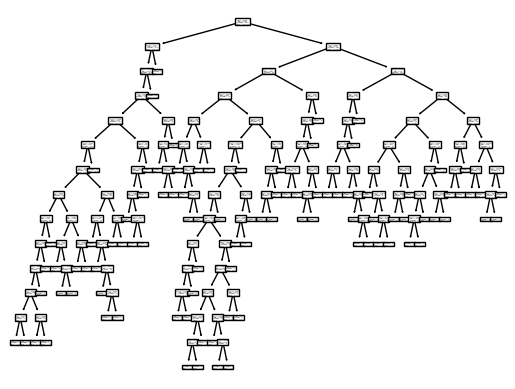

In [16]:
tree.plot_tree(tree2)

In [17]:
# Find confusion matrix
print("Confusion Matrix For Decision Tree Model 2:\n", confusion_matrix(y_test, y_pred2))

Confusion Matrix For Decision Tree Model 2:
 [[98 20]
 [15 67]]


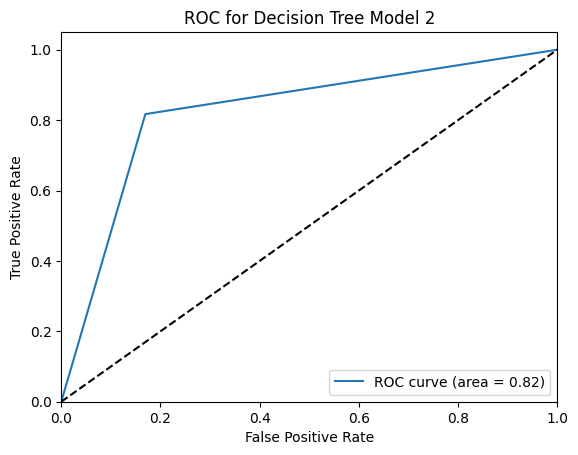

In [18]:
# Compute and plot ROC
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
roc_auc2 = auc(fpr2, tpr2)
plt.figure()
plt.plot(fpr2, tpr2, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Decision Tree Model 2')
plt.legend(loc="lower right")
plt.show()

[Text(0.4869791666666667, 0.9615384615384616, 'x[8] <= 0.5\ngini = 0.498\nsamples = 464\nvalue = [248, 216]'),
 Text(0.18958333333333333, 0.8846153846153846, 'x[2] <= 0.006\ngini = 0.13\nsamples = 214\nvalue = [199, 15]'),
 Text(0.1, 0.8076923076923077, 'x[13] <= 480.0\ngini = 0.408\nsamples = 21\nvalue = [15, 6]'),
 Text(0.08333333333333333, 0.7307692307692307, 'x[5] <= 1.5\ngini = 0.332\nsamples = 19\nvalue = [15, 4]'),
 Text(0.05, 0.6538461538461539, 'x[1] <= 0.13\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(0.03333333333333333, 0.5769230769230769, 'x[1] <= 0.041\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.016666666666666666, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.05, 0.5, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.06666666666666667, 0.5769230769230769, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.11666666666666667, 0.6538461538461539, 'x[14] <= 0.0\ngini = 0.133\nsamples = 14\nvalue = [13, 1]'),
 Text(0.1, 0.5769230769230769, 'gini 

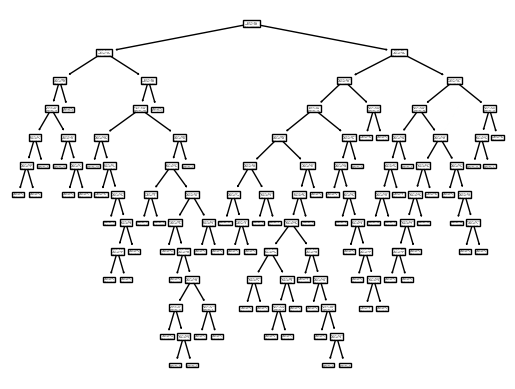

In [19]:
tree.plot_tree(tree3)

In [20]:
# Find confusion matrix
print("Confusion Matrix For Decision Tree Model 3:\n", confusion_matrix(y_test, y_pred3))

Confusion Matrix For Decision Tree Model 3:
 [[100  18]
 [ 13  69]]


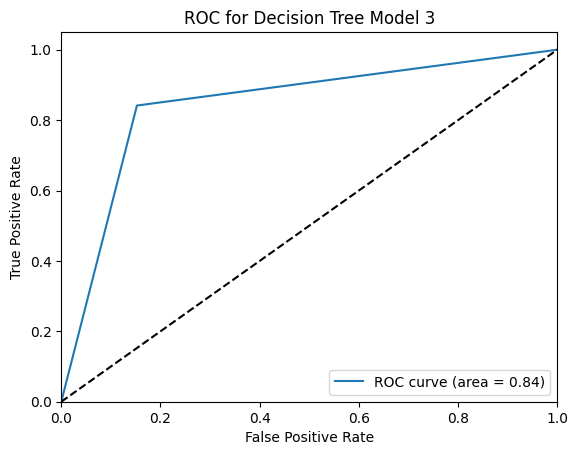

In [21]:
# Compute and plot ROC
fpr3, tpr3, _ = roc_curve(y_test, y_pred3)
roc_auc3 = auc(fpr3, tpr3)
plt.figure()
plt.plot(fpr3, tpr3, label='ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Decision Tree Model 3')
plt.legend(loc="lower right")
plt.show()

# &nbsp;Disscussion on Task 1:

1. Adding splitter='random': the decision tree makes random splits. This introduces a certain level of randomness into the model building process, which can make the model more robust to noisy data and less likely to overfit to the training data. Note the ROC score increased from 0.84 to 0.85 when using splitter='random'. This suggests that introducing some randomness into the model building process may have improved the model’s ability to generalize to unseen data.

2. Adding max_depth=500: It captures more complex patterns in the data, but it is also more likely to overfit to the training data. Note the ROC score decreased from 0.84 to 0.83 when using max_depth=500. This suggests that a tree depth of 500 might be too deep for this data and could be overfitting to the training data, resulting in poorer performance on the test data.

# &nbsp;Task 2: Bagging & Boosting

In [22]:
features = df.drop(15, axis=1)
predicts = df[15]

Bagging: Random Forest

In [23]:
random_forest_model = RandomForestClassifier()

In [24]:
# Use k-fold cross validation to evaluate the model
rf_scores = cross_val_score(random_forest_model, features, predicts, cv=5)
print("The K-Fold Cross Validation Scores for Random Forest Model are:", rf_scores)
print("The highest score is %.2f and the average score is %.2f" % (np.max(rf_scores), np.mean(rf_scores)))

The K-Fold Cross Validation Scores for Random Forest Model are: [0.63909774 0.97744361 0.93984962 0.80451128 0.93181818]
The highest score is 0.98 and the average score is 0.86


Boosting: XGBoost

In [25]:
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [26]:
# Use k-fold cross validation to evaluate the model
xgb_scores = cross_val_score(xgboost_model, X, y, cv=5)
print("The K-Fold Cross Validation Scores for XGBoost Model are:", xgb_scores)
print("The highest score is %.2f and the average score is %.2f" % (np.max(xgb_scores), np.mean(xgb_scores)))

The K-Fold Cross Validation Scores for XGBoost Model are: [0.66917293 0.94736842 0.90977444 0.77443609 0.90151515]
The highest score is 0.95 and the average score is 0.84


Comments on Results:
Both models have similar k fold cross validation scores. The random forest model has the max value of 0.97 and min value of 0.66, with a mean of 0.85. The XGBoost model has the max value of 0.95 and min value of 0.67, with a mean of 0.84.


# &nbsp;Task 3: Evaluation, Comparsion, and Conclusion

In [27]:
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
print("Random Forest Confusion Matrix: \n", confusion_matrix(y_test, y_pred_rf))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

<ipython-input-27-b7ac89e046f9>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_model.fit(X_train, y_train)


Random Forest Confusion Matrix: 
 [[100  18]
 [  6  76]]


In [28]:
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_test)
print("XGBoost Confusion Matrix: \n", confusion_matrix(y_test, y_pred_xgb))
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

XGBoost Confusion Matrix: 
 [[101  17]
 [  7  75]]


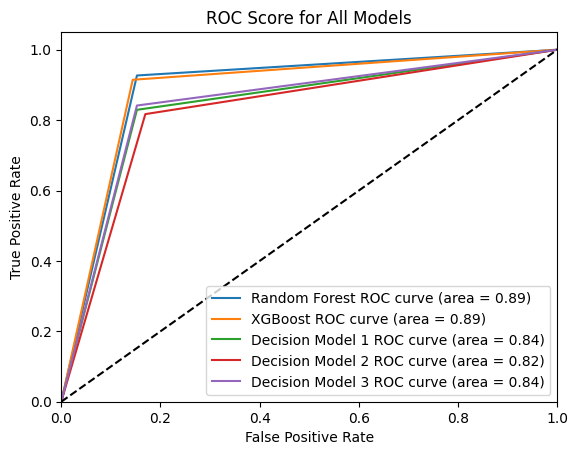

In [29]:
# Plot the ROC curve for both models
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot(fpr1, tpr1, label='Decision Model 1 ROC curve (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Decision Model 2 ROC curve (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Decision Model 3 ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Score for All Models')
plt.legend(loc="lower right")
plt.show()

I used AUC-ROC as the evaluation metric for all 3 (in this case, 5) models.

The ROC metric is particularly suited for binary classification problems since it measures the model’s ability to distinguish between positive and negative classes which provides a single number that summarizes the overall performance of the classifier.

The choice of metric impact the representation of the results. In this homework, K-fold cross-validation is a resampling procedure used to evaluate models on a limited data sample. ROC is a performance measurement for classification problem at various thresholds setting.  So, in essence, k-fold cross-validation and ROC are complementary techniques. K-fold cross-validation provides a robust estimate of the model’s performance by training and testing the model on different subsets of the data, while ROC AUC provides a measure of the model’s ability to distinguish between the positive and negative classes.